In [43]:
from sagemaker import get_execution_role 
role = get_execution_role() 

############사용자 버킷 이름으로 지정해 주세요############
bucket = 'sagemaker-testark'  # s3 사용자 버킷이름 지정
############사용자 버킷 이름으로 지정해 주세요############

In [44]:
%%time 
import pickle, gzip, numpy, urllib.request, json 
# Load the dataset 
urllib.request.urlretrieve("https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz", "mnist.pkl.gz") 
with gzip.open('mnist.pkl.gz', 'rb') as f: 
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1') 


CPU times: user 963 ms, sys: 196 ms, total: 1.16 s
Wall time: 1.64 s


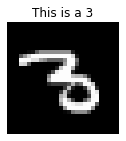

In [45]:
%matplotlib inline 
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (2,10) # 그림 크기 지정

def show_digit(img, caption=' ', subplot=None): 
    if subplot == None: 
        _, (subplot) = plt.subplots(1,1) 
    imgr = img.reshape((28,28)) 
    subplot.axis('off') 
    subplot.imshow(imgr, cmap='gray') 
    plt.title(caption) 
    
show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30])) #30번째 데이터 3을 손으로 쓴 이미지


In [46]:
from sagemaker.amazon.common import write_numpy_to_dense_tensor 
import io 
import boto3 


############사용자 버킷 이름으로 지정해 주세요############
bucket = 'sagemaker-testark' # Amazon S3 버킷 이름 (생성한 버킷과 일치하지 않으면 오류 발생)
############사용자 버킷 이름으로 지정해 주세요############


data_key = 'kmeans_lowlevel_example/data' # 데이터 키 설정
data_location = 's3://{}/{}'.format(bucket, data_key) # 데이터 위치 설정 
print('training data will be uploaded to: {}'.format(data_location)) 

# MNIST 데이터를 Amazon SageMaker 데이터 타입에 맞게 변환 
buf = io.BytesIO() 
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1]) 
buf.seek(0) 
boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf) 

training data will be uploaded to: s3://sagemaker-testark/kmeans_lowlevel_example/data


In [47]:
from sagemaker import KMeans 
data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket) 
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket) 
print('training data will be uploaded to: {}'.format(data_location)) 
print('training artifacts will be uploaded to: {}'.format(output_location)) 
kmeans = KMeans(role=role, # 훈련 결과 읽기 및 쓰기에 사용되는 사용자 IAM 
                train_instance_count=2, # 모델 훈련에 사용할 인스턴스의 수 
                train_instance_type='ml.c4.8xlarge', # 모델 훈련에 사용할 인스턴스의 타입 
                output_path=output_location, # 훈련 결과를 저장할 위치 
                k=10, # 생성할 클러스터의 수, 0부터 9까지의 숫자 분류 문제이기에 10으로 설정 
                data_location=data_location) # 변환된 훈련 데이터를 업로드하는 Amazon S3의 위치

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


training data will be uploaded to: s3://sagemaker-testark/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-testark/kmeans_highlevel_example/output


In [48]:
kmeans.fit(kmeans.record_set(train_set[0]))  

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-12-09 13:47:29 Starting - Starting the training job...
2021-12-09 13:47:37 Starting - Launching requested ML instancesProfilerReport-1639057649: InProgress
......
2021-12-09 13:48:48 Starting - Preparing the instances for training.........
2021-12-09 13:50:25 Downloading - Downloading input data...
2021-12-09 13:50:51 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/09/2021 13:50:53 INFO 140307973875520] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size':

In [49]:
%%time 
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                instance_type='ml.t2.medium') 

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!CPU times: user 249 ms, sys: 29 ms, total: 278 ms
Wall time: 5min 1s


In [50]:
result = kmeans_predictor.predict(valid_set[0][30:31]) 
print(result) 



[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.901206970214844
    }
  }
}
]





Cluster 0:


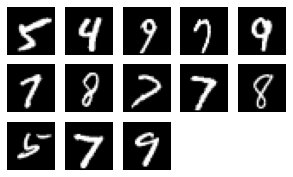




Cluster 1:


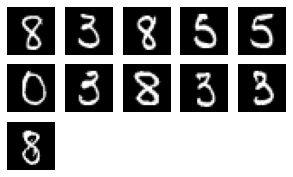




Cluster 2:


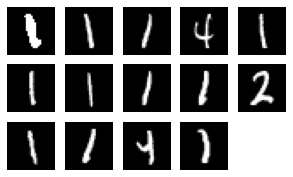




Cluster 3:


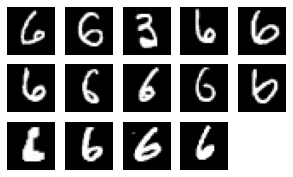




Cluster 4:


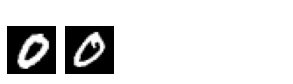




Cluster 5:


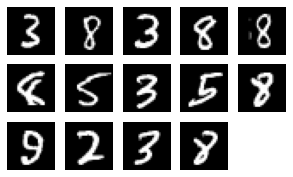




Cluster 6:


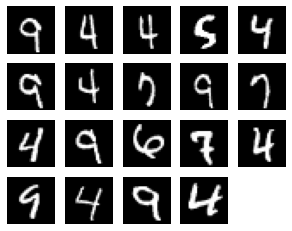




Cluster 7:


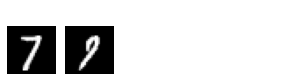




Cluster 8:


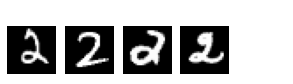




Cluster 9:


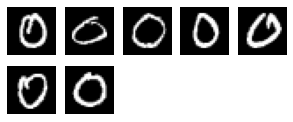

In [51]:
# vaild set에 있는 0번에서 99번까지의 데이터로 클러스터를 예측합니다.
result = kmeans_predictor.predict(valid_set[0][0:100]) 
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result] 
for cluster in range(10): 
    print('\n\n\nCluster {}:'.format(int(cluster))) 
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ] 
    height = ((len(digits)-1)//5) + 1 
    width = 5 
    plt.rcParams["figure.figsize"] = (width,height) 
    _, subplots = plt.subplots(height, width) 
    subplots = numpy.ndarray.flatten(subplots) 
    for subplot, image in zip(subplots, digits): 
        show_digit(image, subplot=subplot) 
    for subplot in subplots[len(digits):]: 
        subplot.axis('off') 
    plt.show() 